In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/dyawitz/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Congratulations!
You built a model. Now you have to present it. 

### How might different audiences respond to the following statments:
    
1. The predictive model I built has an accuracy of 80%.
2. The logistic regression was optimized with L2 regularization, so you know it's good.
3. Gender was more important than age in the predictive model because it had a larger coefficient.
4. Here's the AUC chart that shows how well the model did.

### We'll go over how to make 3 charts for classification:

- Probability Plot
- Confusion Matrix
- ROC Curve


## But first let's review our terms:
![](assets/images/confusion_matrix.png)

## ... and talk about geese

# Example walkthrough
Using a dataset of flight delays let's:
- try to predict whether a flight will be delayed by 15 minutes
- visualize our predictions

In [2]:
df = pd.read_csv('assets/dataset/flight_delays.csv')
df.head(3)

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,Unnamed: 15
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,900,855.0,0.0,NaN
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,900,856.0,0.0,NaN
2,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,1230,1226.0,0.0,NaN


Turn the days of the week into dummy variables and remove null y-values:

In [3]:
df = df.join(pd.get_dummies(df['DAY_OF_WEEK'], prefix='dow'))
df = df[df.DEP_DEL15.notnull()].copy()
df.head(2)

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,...,DEP_TIME,DEP_DEL15,Unnamed: 15,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,...,855.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,...,856.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Run a logistic regression model to predict delays:

In [4]:
import sklearn.linear_model as lm

model = lm.LogisticRegression()
#Only features are time of day and day of the week
features = ['CRS_DEP_TIME', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']

X = df[features]
y = df['DEP_DEL15']
#this is a binary column: was the flight delayed or not?

model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

One effective way to explain your model over particular variables is to plot the predicted variables against the most explanatory variables. For example, with logistic regression, plotting the probability of a class against a variable can help explain the range of effect on the model.

```model.predict_proba``` will give you the probability of an outcome, instead of just the outcome:

In [5]:
## COPY THE LECTURE CODE
df['probability'] = model.predict_proba(df[features]).T[1]

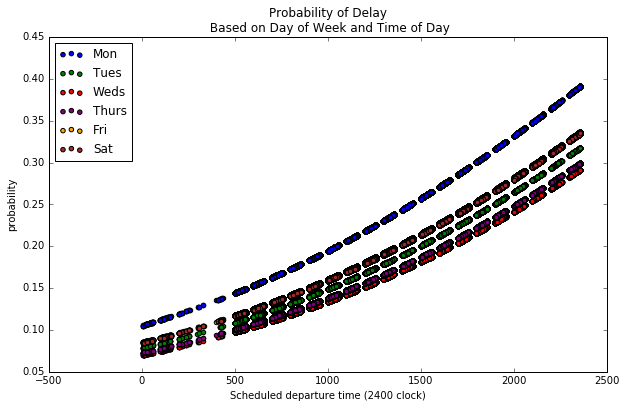

In [6]:
days = ['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']
names = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat'] 
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

plt.figure(figsize=(10,6))
ax = plt.subplot(111)

for e, c in enumerate(colors):
    df[df[days[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', label = names[e], color = c, ax=ax)

ax.legend(loc='upper left')
ax.set_title('Probability of Delay\n Based on Day of Week and Time of Day')
ax.set_xlabel('Scheduled departure time (2400 clock)')

![Plotting Probabilities](assets/images/plotting_proba.png)


### Advantages of a probability plot
- Interpretable! Shows how odds change with respect to one variable
- Can be helpful to demonstrate key takeaways to a stakeholder

### SKlearn has a built in confusion matrix function that lets you see your cm as a 2x2 matrix

First, let's run a model with slightly different inputs

In [12]:
features = ['CRS_DEP_TIME', 'DAY_OF_WEEK', "DAY_OF_MONTH" ]

X = df[features]
y = df['DEP_DEL15']
#this is a binary column: was the flight delayed or not?

model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X)

cm = confusion_matrix(y, predictions)
cm

array([[366501,    832],
       [ 90555,    423]])

### NOTE: SKLearn defines 0 as positive and 1 as negative for classification

### We can write some matplotlib to make that confusion matrix look nice

In [15]:
import matplotlib.patheffects as path_effects

def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline

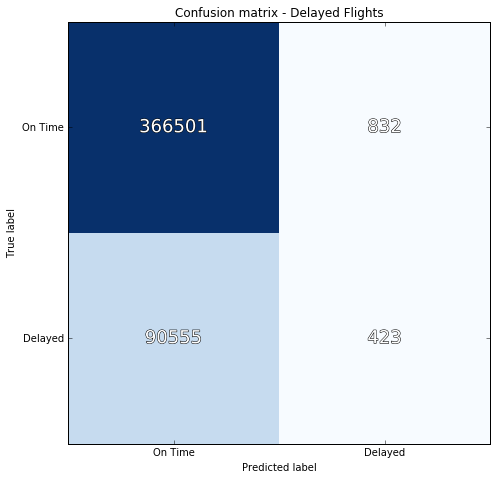

In [17]:
plot_confusion_matrix(cm, title='Confusion matrix - Delayed Flights', labels=['On Time','Delayed'], cmap=plt.cm.Blues)

Ask yourself: What does good coloring on an confusion matrix look like?

### Advantages of a confusion matrix
- Clearly visualizes what the true and false positive rates are
- Can be useful for a non-techincal audience, but requires good labeling and explanation. 

### Sklearn also has an ROC package that exports your false positive rate, true positive rate and thresholds as 3 arrays

In [19]:
from sklearn.metrics import roc_curve
#It takes probability of predicted value as an input:

proba = model.predict_proba(df[features]).T[1]


roc = roc_curve(y, proba)
roc

(array([  0.00000000e+00,   2.99455807e-05,   3.26679062e-05, ...,
          9.99997278e-01,   9.99997278e-01,   1.00000000e+00]),
 array([  0.00000000e+00,   1.09916683e-04,   1.31900020e-04, ...,
          9.99989008e-01,   1.00000000e+00,   1.00000000e+00]),
 array([ 1.54671423,  0.54671423,  0.54650645, ...,  0.0310402 ,
         0.03091436,  0.03066417]))

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title)
    plt.legend(loc='best')
    


### We can plot these in matplotlib too:

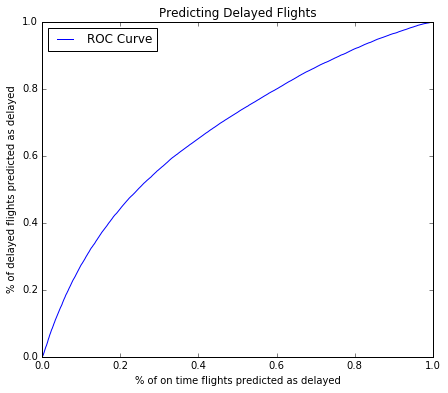

In [21]:
getROCcurve(roc, title='Predicting Delayed Flights', ylabel='% of delayed flights predicted as delayed',\
            xlabel='% of on time flights predicted as delayed')

![](http://gim.unmc.edu/dxtests/roccomp.jpg)

### Advantages of an ROC Curve
- Shows the details of your model's performance as you tune it
- Helpful for stats- and techincal audiences
- Not ideal for non-technical stakeholders

# Guided Practice
Here's a dataset of grad school admissions, based on GPA, rank, and GRE score. In the admit column "1" is admit.

In [22]:
df = pd.read_csv('assets/dataset/collegeadmissions.csv')
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [23]:
## Build a classification model of your choice. 
import sklearn.linear_model as lm
model = lm.LogisticRegression()

features = ['gre', 'gpa', 'rank']
X = df[features]
y = df['admit']

model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
## use your model to predict admissions. 
predictions = model.predict(X)


How well does your prediction do compared to the actual values? 

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc #area under the curve -- which curve?

In [28]:
accuracy_score(y, predictions)

0.71499999999999997

In [29]:
recall_score(y, predictions)

0.22047244094488189

In [30]:
precision_score(y, predictions)

0.65116279069767447

### Confusion Matrix

In [31]:
from sklearn.metrics import confusion_matrix

## Generate a confusion matrix in sklearn
cm = confusion_matrix(y, predictions)
cm

array([[258,  15],
       [ 99,  28]])

In [32]:
sum(predictions)

43

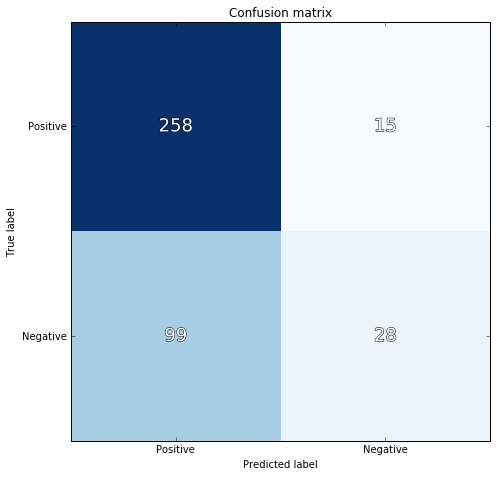

In [33]:
plot_confusion_matrix(cm)

Remember, sklearn calls 0 a postive classification and 1 a negative classificaiton. We know 1 is admit. 

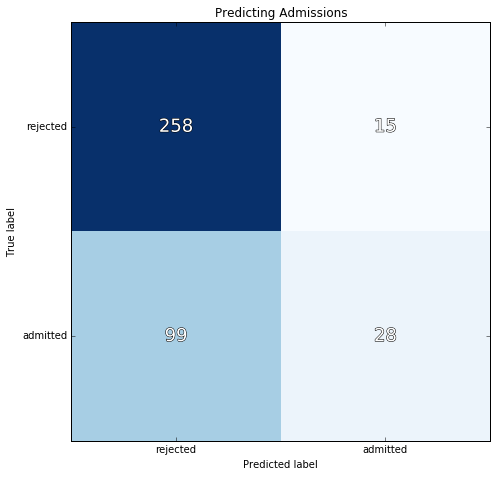

In [34]:
## plot the confusion matrix in matplotlib. 
## BONUS: customize it. Play with the colors, labels and axes
plot_confusion_matrix(cm, title='Predicting Admissions', labels=['rejected', 'admitted'])

### ROC Curve

In [35]:
## Generate an ROC Curve in sklearn
probs = model.predict_proba(X).T[1]

roc = roc_curve(y, probs)
roc

(array([ 0.        ,  0.003663  ,  0.003663  ,  0.00732601,  0.00732601,
         0.01098901,  0.01465201,  0.01465201,  0.02564103,  0.02564103,
         0.02930403,  0.02930403,  0.03296703,  0.03296703,  0.04029304,
         0.04029304,  0.04761905,  0.04761905,  0.05128205,  0.05128205,
         0.05494505,  0.05494505,  0.06227106,  0.06227106,  0.07692308,
         0.07692308,  0.08791209,  0.08791209,  0.09157509,  0.09157509,
         0.0952381 ,  0.0952381 ,  0.0989011 ,  0.0989011 ,  0.1025641 ,
         0.1025641 ,  0.10622711,  0.10622711,  0.11721612,  0.12454212,
         0.12454212,  0.12820513,  0.12820513,  0.13186813,  0.13186813,
         0.13919414,  0.13919414,  0.14652015,  0.14652015,  0.15750916,
         0.15750916,  0.16117216,  0.16117216,  0.17216117,  0.17582418,
         0.17948718,  0.17948718,  0.18315018,  0.18315018,  0.22344322,
         0.22344322,  0.22710623,  0.22710623,  0.23809524,  0.23809524,
         0.24542125,  0.24542125,  0.25641026,  0.2

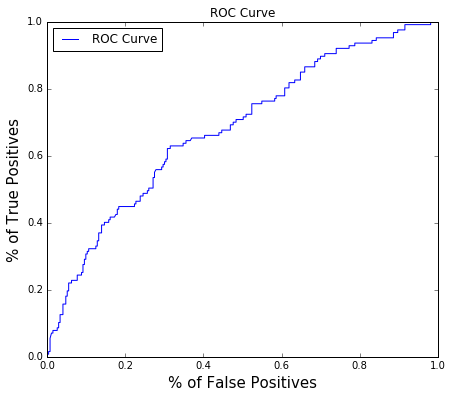

In [40]:
getROCcurve(roc)

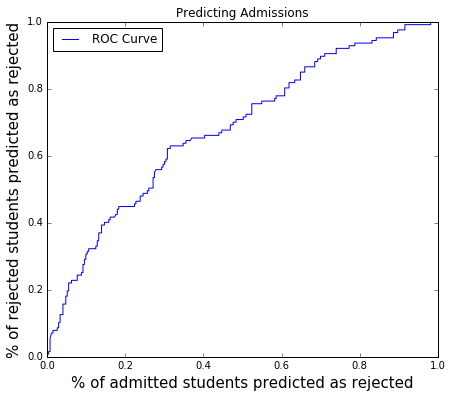

In [41]:
## plot the confusion matrix in matplotlib. 
## BONUS: customize it. Play with the colors and labels
getROCcurve(roc, title='Predicting Admissions', ylabel='% of rejected students predicted as rejected', xlabel="% of admitted students predicted as rejected")